In [2]:
from torchvision import transforms
# import the modules
import os
from os import listdir
from math import hypot
import random

In [3]:
from PIL import Image
import requests
import skimage
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchxrayvision as xrv
import torchvision
from torchvision import transforms

In [4]:
torch.manual_seed(88)
# get the path or directory
path = "/custom_logs/lightning_logs/resnet-xrv-classifier-version1-100epochs/"
model = MyLightningModule.load_from_checkpoint(path)

print(model.learning_rate)
# prints the learning_rate you used in this checkpoint

model.eval()
y_hat = model(x)

# image = Image.open(folder_dir+images_list[1])

# plt.imshow(image)


NameError: name 'MyLightningModule' is not defined

In [179]:
tf_randomrot = transforms.RandomRotation(degrees=(-20,20))

In [180]:
def rotation_augmentation(folder_dir, target_dir):
    images_list = os.listdir(folder_dir)
    
    for image_name in images_list:
        image = Image.open(folder_dir+image_name)
        height, width = image.size
        hypotenouse = hypot(height, width)
        padding = (int((hypotenouse-height)/2*75/100), int((hypotenouse-width)/2*75/100))
        tf_padding = transforms.Pad(padding=padding)
        padded_image  = tf_padding(image)
        rotated_image = tf_randomrot(padded_image)

        file_name, file_ext = os.path.splitext(image_name)

        rotated_image.save(target_dir+file_name+'.png')
    

In [181]:
rotation_augmentation(folder_dir, target_dir)
rotation_augmentation(folder_dir2, target_dir2)

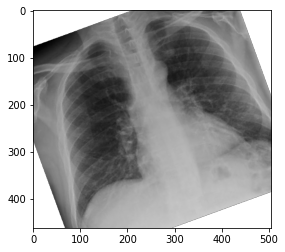

In [166]:


rotated_image = tf_randomrot(image)

plt.imshow(rotated_image)

file_name, file_ext = os.path.splitext(images_list[1])

rotated_image.save(target_dir+file_name+'.png')

(67, 83)


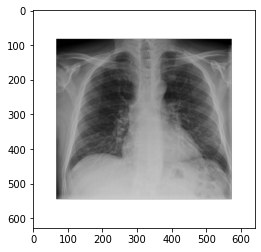

In [78]:
padding = (int((hypotenouse-height)/2*75/100), int((hypotenouse-width)/2*75/100))
print(padding)
tf_padding = transforms.Pad(padding=padding)
padded_image  = tf_padding(image)

plt.imshow(padded_image)

In [79]:
tf_randomrot = transforms.RandomRotation(degrees=(20,20))

In [159]:
padded_image = tf_randomrot(padded_image)
tf_randomrot.get_params((-20,20))

13.582332611083984

In [81]:
padded_image.save(target_dir+file_name+'rotated.png')

In [7]:
ataset_classes = ['Clean','Dirty']
    
# loader = DataLoader(model.dataset_test, batch_size=1, shuffle=True)


for idx,(img,label) in enumerate(loader):
    preds.add(label)
#     print(idx)

print(preds)

NameError: name 'loader' is not defined

In [9]:
torch.tensor([1]).item()

1

In [15]:
#!/usr/bin/env python
# coding: utf-8

# In[5]:


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms, models # --> new
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import DataLoader, random_split 
import torchxrayvision as xrv

import requests
from PIL import Image


# In[6]:



# In[1]:


def tensor_to_imgnumpy_simple(image):
    imgnumpy = image
    imgnumpy = imgnumpy.squeeze()
    return imgnumpy


# In[3]:



# In[7]:


class CustomNormalize(torch.nn.Module):
    """Normalize a tensor image with mean and standard deviation.
    This transform does not support PIL Image.
    Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
    channels, this transform will normalize each channel of the input
    ``torch.*Tensor`` i.e.,
    ``output[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts out of place, i.e., it does not mutate the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation in-place.
    """

    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, img: np.ndarray) -> np.ndarray:
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        return (2 * (img.astype(np.float32) / 255) - 1.) * 1024

#     def __repr__(self) -> str:
#         return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

class ToNumpy(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, img):
        return np.array(img)
    
class AddColorChannel(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, img):
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")
        return img[None, :, :]


# In[24]:


warning_log = {}

def fix_resolution(x, resolution: int, model: nn.Module):
        """Check resolution of input and resize to match requested."""

        # just skip it if upsample was removed somehow
        if not hasattr(model, 'upsample') or (model.upsample == None):
            return x

        if (x.shape[2] != resolution) | (x.shape[3] != resolution):
            if not hash(model) in warning_log:
                print("Warning: Input size ({}x{}) is not the native resolution ({}x{}) for this model. A resize will be performed but this could impact performance.".format(x.shape[2], x.shape[3], resolution, resolution))
                warning_log[hash(model)] = True
            return model.upsample(x)
        return x

def warn_normalization(x):
    """Check normalization of input and warn if possibly wrong. When 
    processing an image that may likely not have the correct 
    normalization we can issue a warning. But running min and max on 
    every image/batch is costly so we only do it on the first image/batch.
    """
    
    # Only run this check on the first image so we don't hurt performance.
    if not "norm_check" in warning_log:
        x_min = x.min()
        x_max = x.max()
        if torch.logical_or(-255 < x_min, x_max < 255) or torch.logical_or(x_min < -1024, 1024 < x_max):
            print(f'Warning: Input image does not appear to be normalized correctly. The input image has the range [{x_min:.2f},{x_max:.2f}] which doesn\'t seem to be in the [-1024,1024] range. This warning may be wrong though. Only the first image is tested and we are only using a heuristic in an attempt to save a user from using the wrong normalization.')
            warning_log["norm_correct"] = False
        else:
            warning_log["norm_correct"] = True
              
        warning_log["norm_check"] = True
    
class FinetunedModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # load pretrained model
        model = xrv.models.DenseNet(weights="densenet121-res224-all")
        
        self.features = model.features
        
        self.classifier = model.classifier
        
#         freeze the feature learning
        for param in self.features.parameters():
              param.requires_grad = False
        
        # change the number of output classes of the last layer
        # this is useless line as it the number of output classes is already set to be 10
        self.classifier = nn.Linear(
            in_features=self.classifier.in_features,
            out_features=2)
        
        # follow https://pytorch.org/hub/pytorch_vision_alexnet/
        tf_tonumpy = ToNumpy()
        tf_custom_normalize = CustomNormalize()
        tf_add_color_channel = AddColorChannel()
        tf_totensor = transforms.ToTensor()
        self.tf_compose = transforms.Compose([
            tf_tonumpy,
            tf_custom_normalize,
            tf_add_color_channel,
#             xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(224),
#             tf_totensor
        ])
    
    def features2(self, x):
        x = fix_resolution(x, 224, self)
        warn_normalization(x)
        
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        return out
    
    def forward(self, x):
        x = fix_resolution(x, 224, self)
        
        features = self.features2(x)
        out = self.classifier(features)
        
        if hasattr(self, 'apply_sigmoid') and self.apply_sigmoid:
            out = torch.sigmoid(out)
        
        if hasattr(self,"op_threshs") and (self.op_threshs != None):
            out = torch.sigmoid(out)
            out = op_norm(out, self.op_threshs)
        return out

    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        
        outputs = self.forward(inputs)
#         import pdb; pdb.set_trace()
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            dataset_full = datasets.ImageFolder(root='./data/Batch 1/Train/', transform=self.tf_compose)
            
            # split
            SIZE_TRAIN_DATA = int(len(dataset_full)*0.75)
            SIZE_VAL_DATA = len(dataset_full)-SIZE_TRAIN_DATA
            self.dataset_train, self.dataset_val = random_split(dataset_full, [SIZE_TRAIN_DATA,SIZE_VAL_DATA])
            
        if stage == 'test' or stage is None:
            self.dataset_test = datasets.ImageFolder(root='./data//Batch 1/Test/', transform=self.tf_compose)
            
#         import pdb; pdb.set_trace()
            
    def train_dataloader(self): 
        return DataLoader(self.dataset_train, batch_size=50, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=50, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=50, num_workers=0)


# In[25]:


# pl.seed_everything(88) # --> for consistency, change the number with your favorite number :D

# model = FinetunedModel()

# # most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# try:
#     trainer = pl.Trainer(gpus=1,max_epochs=100,default_root_dir='./custom_logs')
# except Exception as e:
#     # most likely due to GPU, so fallback to non GPU
#     print(e)
#     trainer = pl.Trainer(max_epochs=100,default_root_dir='./custom_logs')

# trainer.fit(model)

# trainer.test()




pl.seed_everything(88)
path = "./checkpoint_test/densenet-xrv-classifier-version1-100epochs/checkpoints/epoch=99-step=1100.ckpt"
model = FinetunedModel.load_from_checkpoint(checkpoint_path=path)

# trainer = pl.Trainer()
# trainer.test(model)

# dataset_classes = ['Clean','Dirty']
    
# loader = DataLoader(model.dataset_test, batch_size=1, shuffle=True)


# targets = []
# preds = []

# for idx,(img,label) in enumerate(loader):
#     targets.append(label.item())
    
#     try:
#         pred = model.forward(img.cuda())
#     except Exception as e:
#         pred =  model.forward(img)
# #         print(e)

#     preds.append(pred.argmax().item())


 

# from torchmetrics import ConfusionMatrix
# from torchmetrics import AUC

# targets_torch = torch.tensor(targets)
# preds_torch = torch.tensor(preds)

# print(preds)
# print(targets)

# confmat = ConfusionMatrix(num_classes=2)
# print("Confusion Matrix: \nClean - Dirty")
# print(confmat(preds_torch, targets_torch))

# auc = AUC(reorder=True)
# auc.update(preds_torch, targets_torch)
# print("AUC score: ")
# print(auc.compute())


dataset_classes = ['Clean','Dirty']

def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy_simple(imgnumpy))
    plt.title(dataset_classes[label])
    
loader = DataLoader(model.dataset_test, batch_size=1, shuffle=True)

plt.figure(figsize=(20, 8))
for idx,(img,label) in enumerate(loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    try:
        pred = model.forward(img.cuda())
    except Exception as e:
        pred =  model.forward(img)
        print(e)

    title_dataset = dataset_classes[label]
    title_pred = dataset_classes[pred.argmax().item()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 40-1:
        break
        
plt.tight_layout()



Global seed set to 88


AttributeError: 'FinetunedModel' object has no attribute 'dataset_test'